In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
import math
from utils import *
import seaborn as sns
from scipy import stats

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
edau = EDAUtils()
statsu = StatsUtils()

In [11]:
# Set up paths
script_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
tableu_dir = os.path.join(root_dir, 'tableau')
porcessed_data_dir = os.path.join(script_dir, 'processed_data')

In [12]:
k = 4
eps = 8
n_rows = 5000
# Load labeled data
labeled_scenarios_df = pd.read_csv(os.path.join(porcessed_data_dir, f'bardis_ensemble_python_ver_{n_rows}_k{k}_eps{eps}.csv'))
labeled_scenarios_df

Resources   Economy  Bureaucracy  Pollution   time  run_id  \
0         1.000000  1.000000     1.000000   1.000000    0.0     1.0   
1         0.968867  1.015463     1.002266   0.989368    0.2     1.0   
2         0.937852  1.030392     1.004657   0.978862    0.4     1.0   
3         0.907016  1.044750     1.007171   0.968459    0.6     1.0   
4         0.876418  1.058504     1.009802   0.958140    0.8     1.0   
...            ...       ...          ...        ...    ...     ...   
5004995  -0.000017 -0.000201     0.043258   0.045221  199.2  5000.0   
5004996  -0.000017 -0.000201     0.043100   0.045058  199.4  5000.0   
5004997  -0.000017 -0.000201     0.042942   0.044895  199.6  5000.0   
5004998  -0.000017 -0.000201     0.042785   0.044733  199.8  5000.0   
5004999  -0.000017 -0.000201     0.042629   0.044572  200.0  5000.0   

         kmeans_cluster_id  dbscan_cluster_id  
0                        0                  0  
1                        0                  0  
2                        0                  0  
3                        0                  0  
4                        0                  0  
...                    ...                ...  
5004995                  0                  0  
5004996                  0                  0  
5004997                  0                  0  
5004998                  0                  0  
5004999                  0                  0  

[5005000 rows x 8 columns]

In [13]:
# Create a test subset of the data
test_df = labeled_scenarios_df[labeled_scenarios_df['run_id'] < 6].copy()
test_df

Resources   Economy  Bureaucracy  Pollution   time  run_id  \
0      1.000000  1.000000     1.000000   1.000000    0.0     1.0   
1      0.968867  1.015463     1.002266   0.989368    0.2     1.0   
2      0.937852  1.030392     1.004657   0.978862    0.4     1.0   
3      0.907016  1.044750     1.007171   0.968459    0.6     1.0   
4      0.876418  1.058504     1.009802   0.958140    0.8     1.0   
...         ...       ...          ...        ...    ...     ...   
5000  -0.000198  0.864210     1.501737   0.321088  199.2     5.0   
5001  -0.000198  0.864347     1.501974   0.321139  199.4     5.0   
5002  -0.000198  0.864483     1.502211   0.321189  199.6     5.0   
5003  -0.000198  0.864620     1.502449   0.321240  199.8     5.0   
5004  -0.000198  0.864756     1.502686   0.321291  200.0     5.0   

      kmeans_cluster_id  dbscan_cluster_id  
0                     0                  0  
1                     0                  0  
2                     0                  0  
3                     0                  0  
4                     0                  0  
...                 ...                ...  
5000                  0                  0  
5001                  0                  0  
5002                  0                  0  
5003                  0                  0  
5004                  0                  0  

[5005 rows x 8 columns]

## Label Experimental Design and EDA

In [14]:
# Load exp_design data
exp_design_df = pd.read_csv(os.path.join(tableu_dir, f'exp_design_python_ver_{n_rows}.csv'))
exp_design_df.head()

k_resources:X  ef_economy_resources_on_prod:X  ef_bureaucracy_on_prod:X  \
0       1.356781                        1.319255                  1.004633   
1       1.367342                        1.479775                  1.405237   
2       0.904624                        1.123620                  1.457622   
3       0.838680                        1.129161                  0.775871   
4       0.863039                        0.817668                  1.337594   

   k_deprec:X  ef_pollution_on_depreciation:X  k_bureaucracy:X  \
0    1.053625                        1.162683         0.725813   
1    0.641620                        0.516117         0.590530   
2    1.272073                        1.274685         1.236315   
3    0.995464                        1.118074         0.798937   
4    0.730111                        0.697973         0.914906   

   ef_economy_on_bureaucracy:X  k_decay_bureaucracy:X  \
0                     1.133347               0.862697   
1                     1.249360               1.367622   
2                     0.992176               1.158104   
3                     0.744974               1.047413   
4                     1.091851               1.220748   

   ef_pollution_on_bureaucracy:X  k_pollution:X  k_pollution_decay:X  run_id  
0                       0.649155       1.383066             1.477041       1  
1                       1.200454       1.242771             1.186953       2  
2                       1.085033       0.604734             0.599206       3  
3                       1.194530       0.543057             0.698657       4  
4                       0.653440       1.128317             1.206587       5

In [15]:
# Create a df that has the unique run ids and the corresponding cluster id
runs_cluster_mapping = labeled_scenarios_df.groupby('run_id')[['kmeans_cluster_id', 'dbscan_cluster_id']].first().reset_index()
runs_cluster_mapping

run_id  kmeans_cluster_id  dbscan_cluster_id
0        1.0                  0                  0
1        2.0                  0                  0
2        3.0                  0                  0
3        4.0                  0                  0
4        5.0                  0                  0
...      ...                ...                ...
4995  4996.0                  0                  0
4996  4997.0                  0                  0
4997  4998.0                  1                  0
4998  4999.0                  0                  0
4999  5000.0                  0                  0

[5000 rows x 3 columns]

In [16]:
# Merge the exp_design_df with the runs_cluster_mapping to get the cluster ids for each run
exp_design_df = pd.merge(exp_design_df, runs_cluster_mapping, on='run_id', how='left')
exp_design_df

k_resources:X  ef_economy_resources_on_prod:X  ef_bureaucracy_on_prod:X  \
0          1.356781                        1.319255                  1.004633   
1          1.367342                        1.479775                  1.405237   
2          0.904624                        1.123620                  1.457622   
3          0.838680                        1.129161                  0.775871   
4          0.863039                        0.817668                  1.337594   
...             ...                             ...                       ...   
4995       1.291676                        1.226146                  1.345812   
4996       1.074320                        1.496463                  1.027421   
4997       0.718964                        1.132375                  1.322201   
4998       0.811140                        0.503341                  0.643905   
4999       0.958394                        1.114275                  0.530682   

      k_deprec:X  ef_pollution_on_depreciation:X  k_bureaucracy:X  \
0       1.053625                        1.162683         0.725813   
1       0.641620                        0.516117         0.590530   
2       1.272073                        1.274685         1.236315   
3       0.995464                        1.118074         0.798937   
4       0.730111                        0.697973         0.914906   
...          ...                             ...              ...   
4995    0.948975                        0.620518         0.704803   
4996    0.841568                        0.780839         1.400839   
4997    0.612476                        0.682893         0.998169   
4998    1.412550                        1.006084         0.841147   
4999    0.960571                        0.875452         1.423101   

      ef_economy_on_bureaucracy:X  k_decay_bureaucracy:X  \
0                        1.133347               0.862697   
1                        1.249360               1.367622   
2                        0.992176               1.158104   
3                        0.744974               1.047413   
4                        1.091851               1.220748   
...                           ...                    ...   
4995                     0.888834               1.377698   
4996                     1.312481               1.338219   
4997                     1.361731               0.801206   
4998                     1.021082               1.393027   
4999                     1.161039               0.851153   

      ef_pollution_on_bureaucracy:X  k_pollution:X  k_pollution_decay:X  \
0                          0.649155       1.383066             1.477041   
1                          1.200454       1.242771             1.186953   
2                          1.085033       0.604734             0.599206   
3                          1.194530       0.543057             0.698657   
4                          0.653440       1.128317             1.206587   
...                             ...            ...                  ...   
4995                       1.083848       0.536703             1.440108   
4996                       0.824002       0.719864             0.936692   
4997                       1.136865       1.068550             1.039549   
4998                       1.044060       1.091542             1.005045   
4999                       0.735024       1.450163             0.618490   

      run_id  kmeans_cluster_id  dbscan_cluster_id  
0          1                  0                  0  
1          2                  0                  0  
2          3                  0                  0  
3          4                  0                  0  
4          5                  0                  0  
...      ...                ...                ...  
4995    4996                  0                  0  
4996    4997                  0                  0  
4997    4998                  1                  0  
4998    4999                  0                  0  

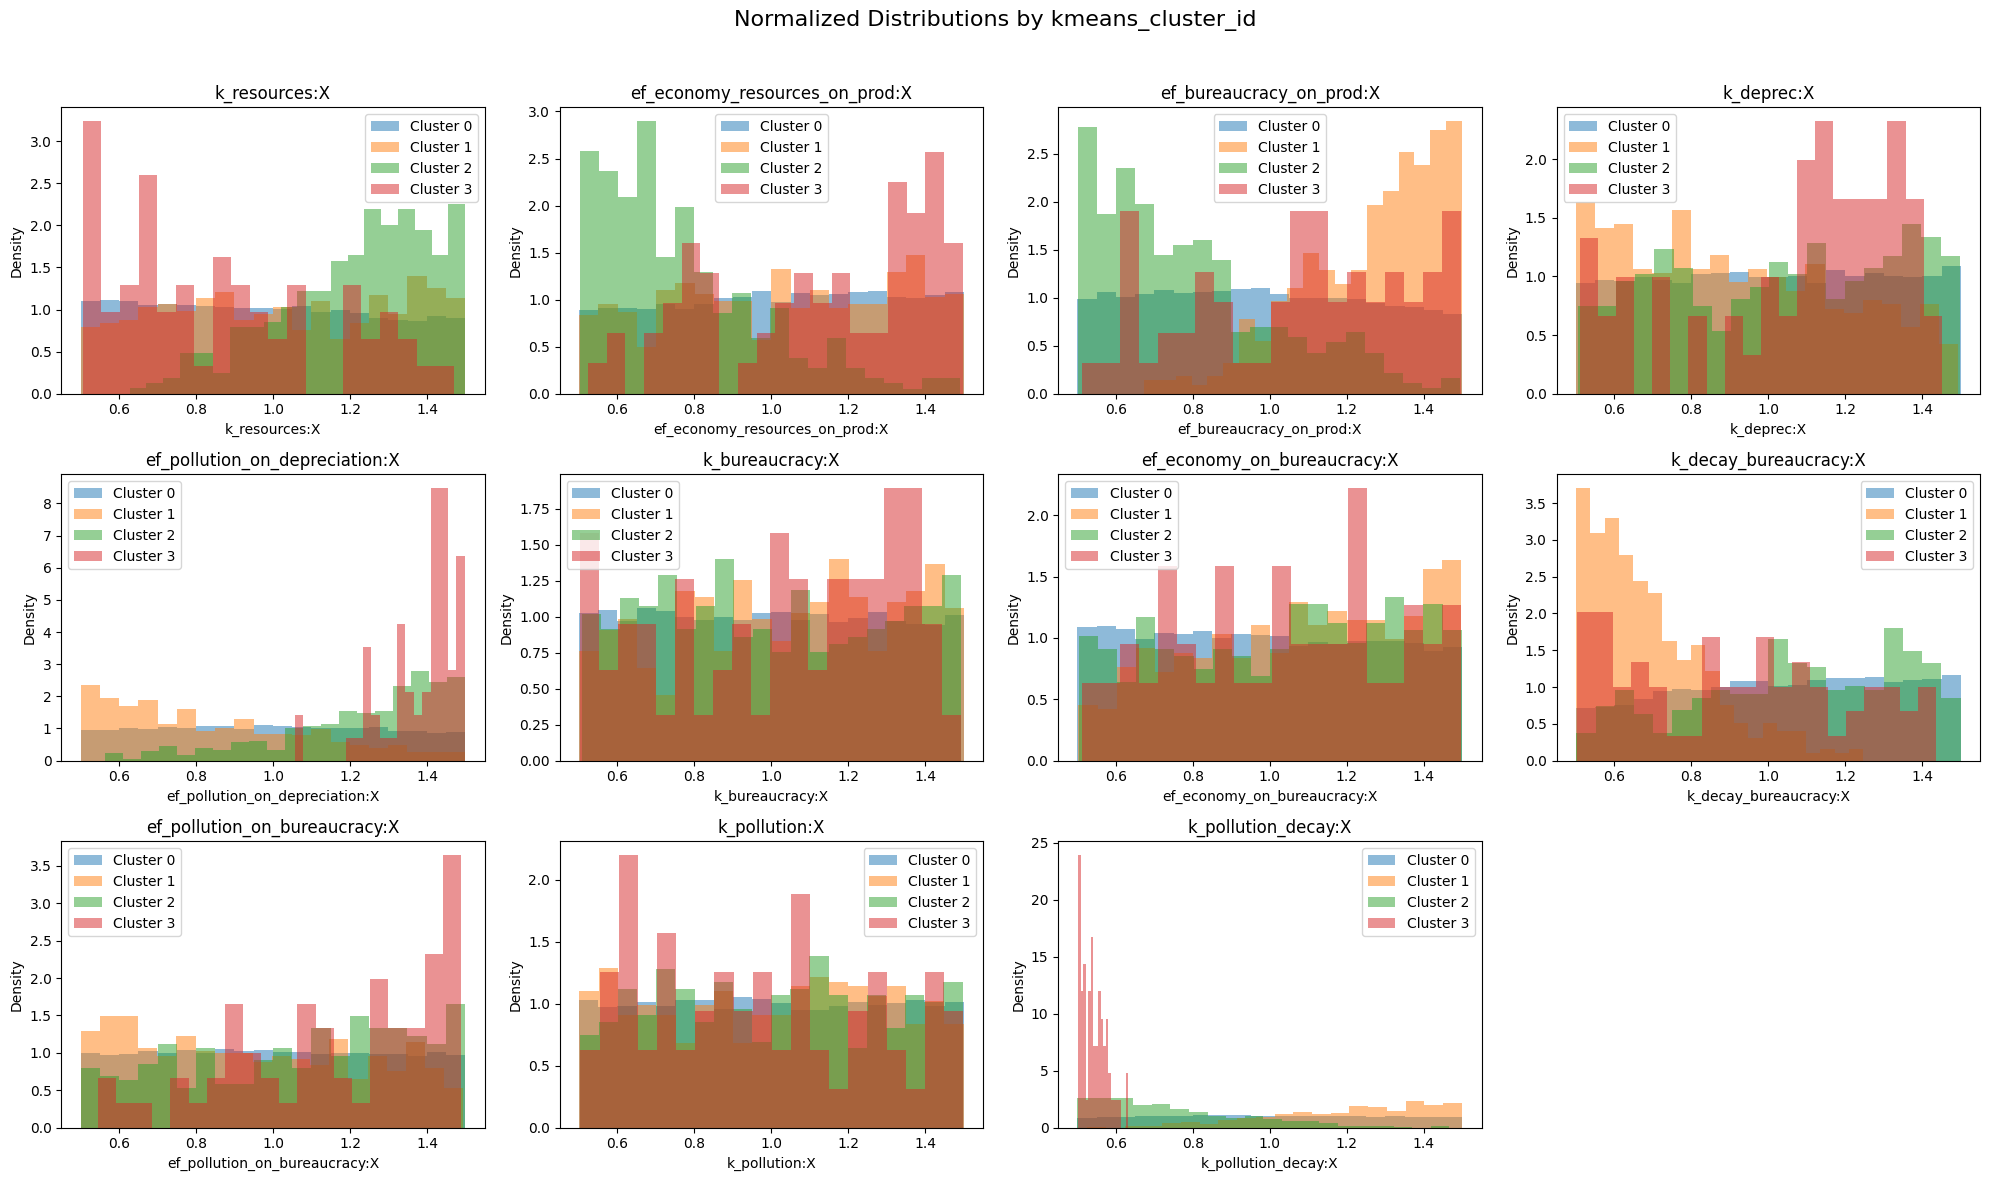

In [17]:
statsu.plot_distribution_by_cluster(exp_design_df, 'kmeans_cluster_id', density=True)

In [18]:
conf = 0.95
ci_df = statsu.compute_confidence_intervals(exp_design_df,
                                    'kmeans_cluster_id',
                                    conf)

ci_df.head()

kmeans_cluster_id                        variable      mean  lower_ci  \
0                  0                   k_resources:X  0.979464  0.970602   
1                  0  ef_economy_resources_on_prod:X  1.016287  1.007474   
2                  0        ef_bureaucracy_on_prod:X  0.984375  0.975655   
3                  0                      k_deprec:X  1.006032  0.997124   
4                  0  ef_pollution_on_depreciation:X  0.993253  0.984551   

   upper_ci     n  
0  0.988326  4031  
1  1.025100  4031  
2  0.993094  4031  
3  1.014939  4031  
4  1.001955  4031

In [19]:
# Lists of parameters per flow
resource_inflow = ['k_resources:X']
extractive_pollution = ["k_pollution:X"]
production = ["ef_economy_resources_on_prod:X", "ef_bureaucracy_on_prod:X"]
depreciation = ["k_deprec:X", "ef_pollution_on_depreciation:X"]
bureaucracy_creation = ["ef_economy_on_bureaucracy:X", "k_bureaucracy:X"]
bureaucracy_decay = ["k_decay_bureaucracy:X", "ef_pollution_on_bureaucracy:X"]
pollution_abatement = ["k_pollution_decay:X"]


# Join the flow lists into a single list
resources_params = resource_inflow + production + extractive_pollution
economy_params = production + depreciation + bureaucracy_creation
bureaucracy_params = bureaucracy_creation + bureaucracy_decay
poluttion_params = depreciation + bureaucracy_decay + extractive_pollution + pollution_abatement

print(f"Resources params: {resources_params}")
print(f"Economy params: {economy_params}")
print(f"Bureaucracy params: {bureaucracy_params}")
print(f"Pollution params: {poluttion_params}")

Resources params: ['k_resources:X', 'ef_economy_resources_on_prod:X', 'ef_bureaucracy_on_prod:X', 'k_pollution:X']
Economy params: ['ef_economy_resources_on_prod:X', 'ef_bureaucracy_on_prod:X', 'k_deprec:X', 'ef_pollution_on_depreciation:X', 'ef_economy_on_bureaucracy:X', 'k_bureaucracy:X']
Bureaucracy params: ['ef_economy_on_bureaucracy:X', 'k_bureaucracy:X', 'k_decay_bureaucracy:X', 'ef_pollution_on_bureaucracy:X']
Pollution params: ['k_deprec:X', 'ef_pollution_on_depreciation:X', 'k_decay_bureaucracy:X', 'ef_pollution_on_bureaucracy:X', 'k_pollution:X', 'k_pollution_decay:X']


In [23]:
# # Plot the confidence intervals
# for variable in ci_df['variable'].unique():
#     statsu.plot_boxplot_with_error_bar(exp_design_df, ci_df, variable, 'kmeans_cluster_id', conf)

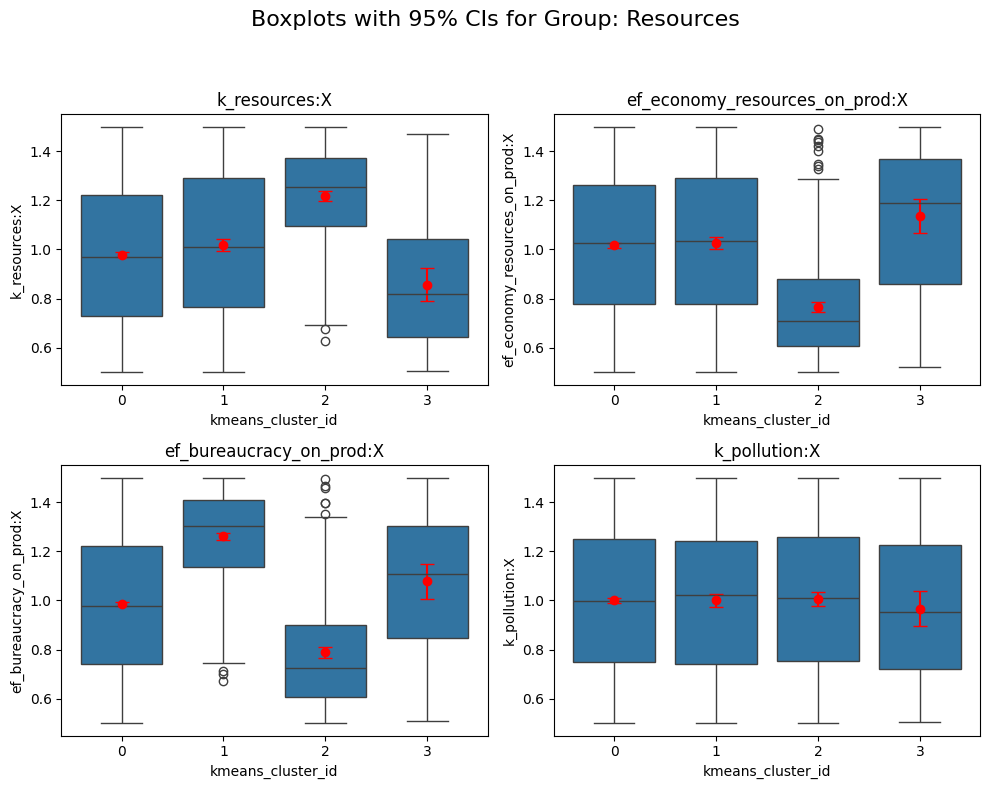

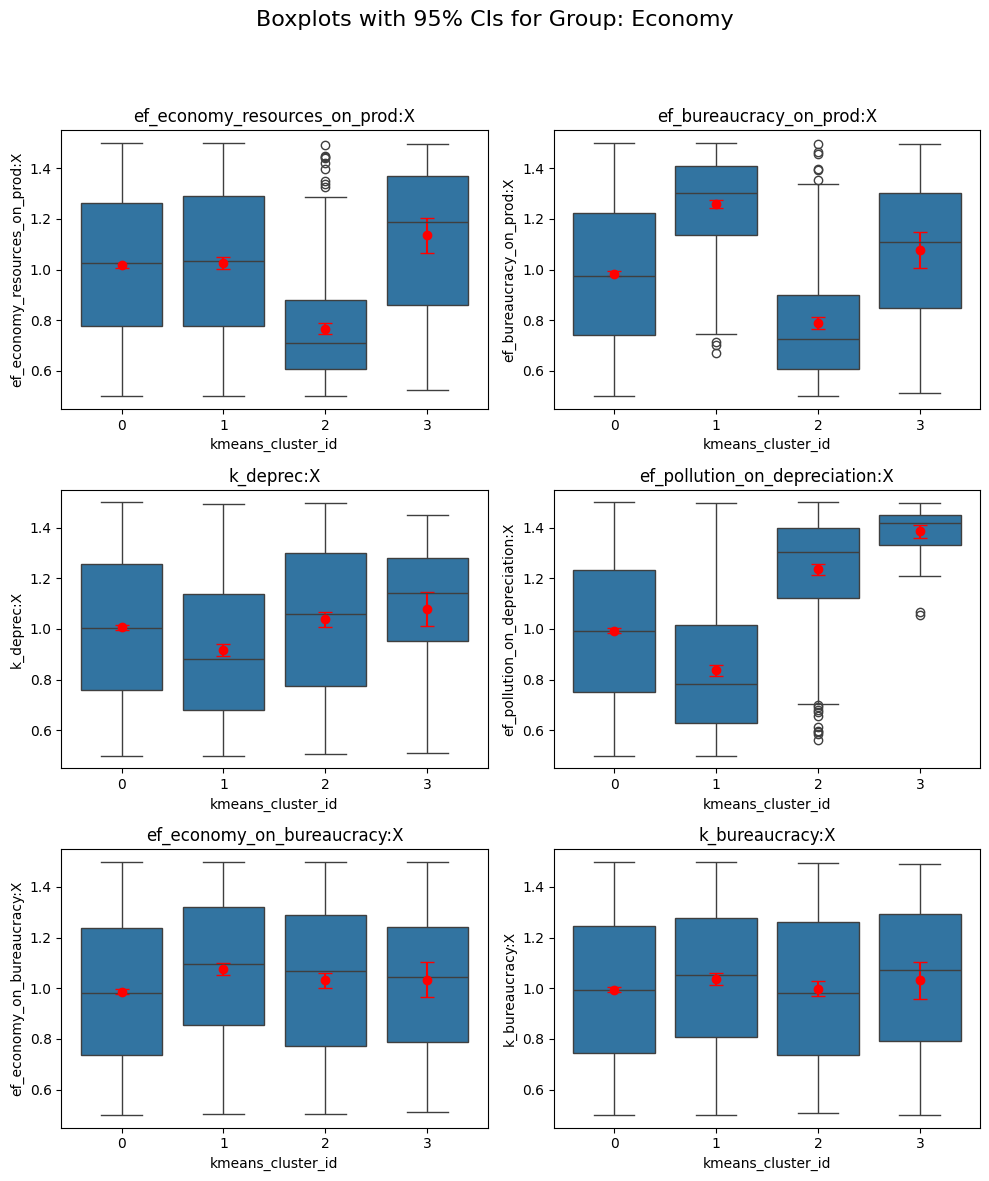

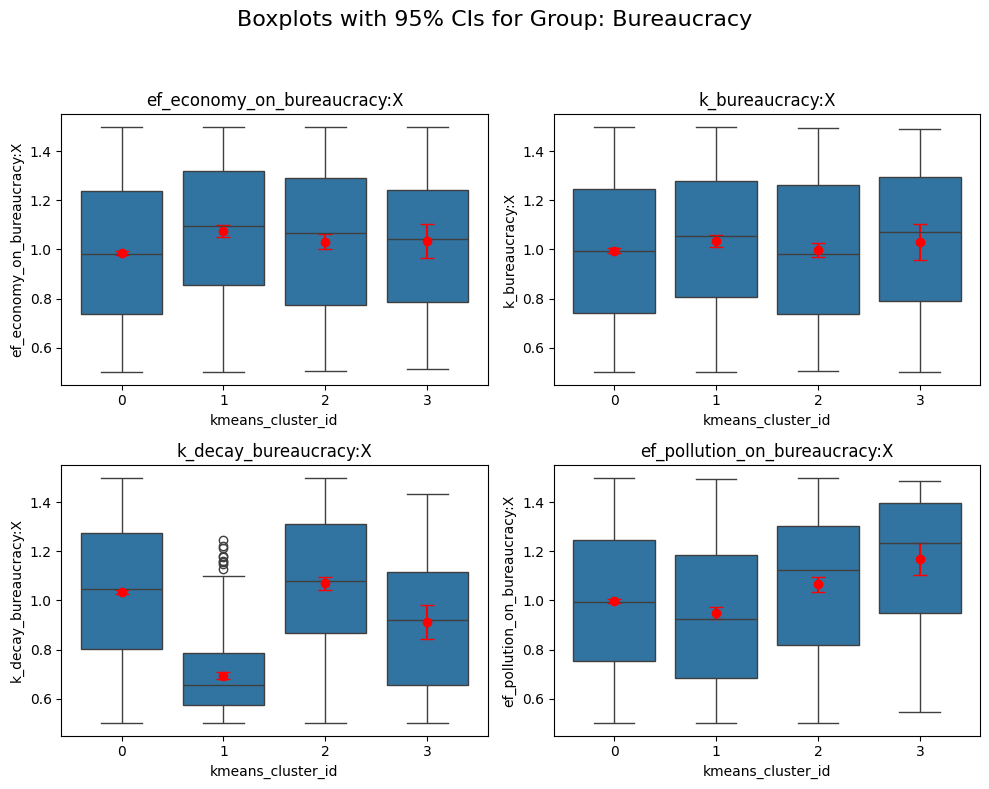

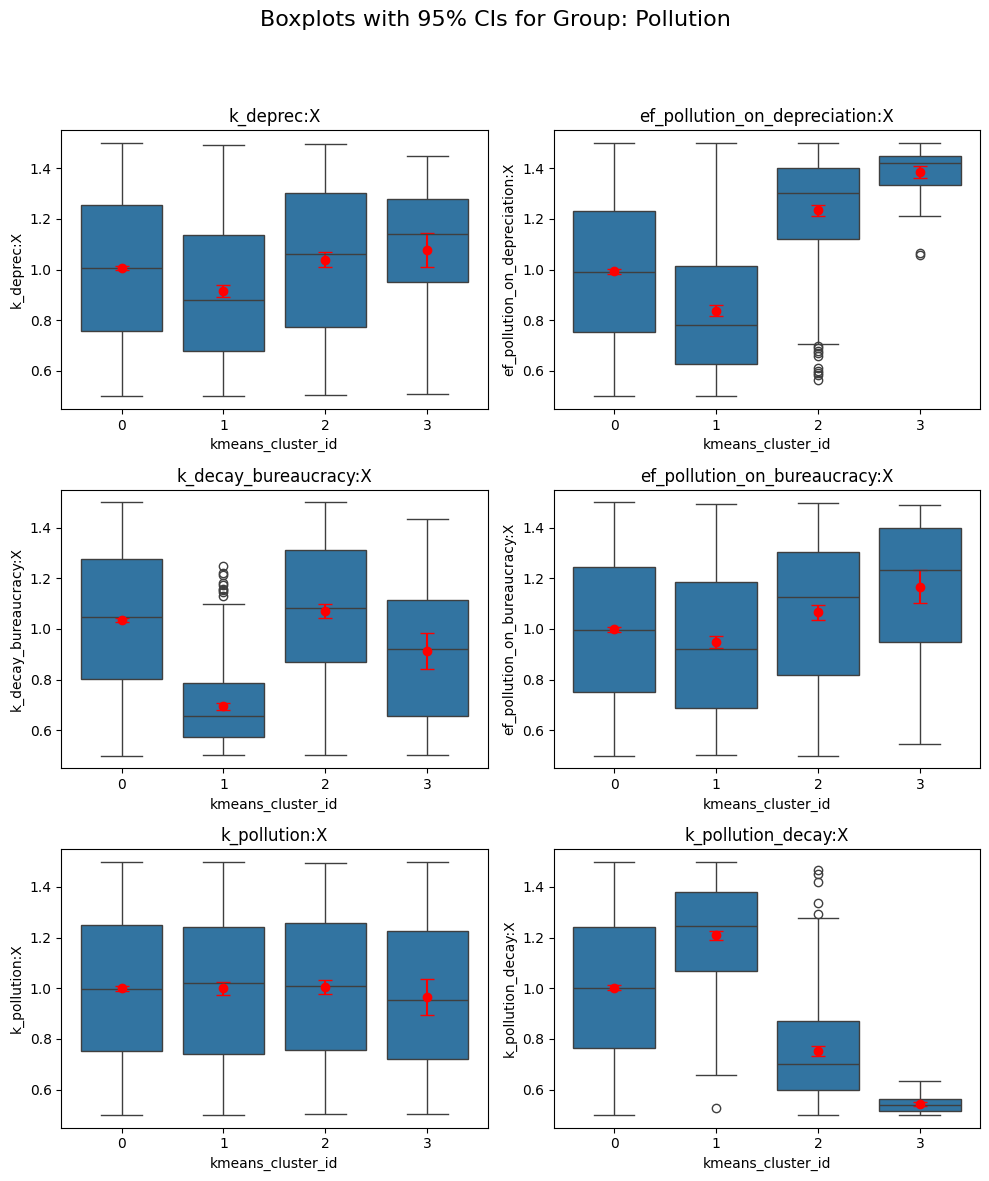

In [26]:
var_groups = {
    'resources': resources_params,
    'economy': economy_params,
    'bureaucracy': bureaucracy_params,
    'pollution': poluttion_params
}
# Plot the confidence intervals for each group
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['resources'], 'kmeans_cluster_id', 'Resources', conf)
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['economy'], 'kmeans_cluster_id', 'Economy', conf)
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['bureaucracy'], 'kmeans_cluster_id', 'Bureaucracy', conf)
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['pollution'], 'kmeans_cluster_id', 'Pollution', conf)

In [27]:
def get_summary_stats_from_exp_design(df, clustering_type='kmeans'):
    """
    Get summary stats from the experimental design data frame.
    
    Parameters:
      df (DataFrame): Input experimental design data frame.
      clustering_type (str): Type of clustering to use ('kmeans' or 'dbscan').
      
    Returns:
      DataFrame: Summary statistics with explicit column names.
    """
    # Drop run id column
    df = df.drop(columns=['run_id'])
    
    # Drop the cluster_id column not relevant to the chosen clustering type
    if clustering_type == 'kmeans':
        df = df.drop(columns=['dbscan_cluster_id'])
    elif clustering_type == 'dbscan':
        df = df.drop(columns=['kmeans_cluster_id'])
    
    # Define the aggregation functions with explicit names using the new named aggregation syntax.
    # Here we aggregate all columns (except the clustering column) with the same set of stats.
    agg_funcs = {
        'mean': 'mean',
        'median': 'median',
        'max': 'max',
        'min': 'min',
        'q1': lambda x: x.quantile(0.25),
        'q3': lambda x: x.quantile(0.75),
        'iqr': lambda x: x.quantile(0.75) - x.quantile(0.25)
    }
    
    # Identify the value columns to aggregate (all columns except the grouping column)
    group_col = f'{clustering_type}_cluster_id'
    value_columns = [col for col in df.columns if col != group_col]
    
    # Use the named aggregation feature. Since the aggregation is the same for every column,
    # we build a dictionary comprehension to apply each aggregation to every value column.
    summary_stats_df = df.groupby(group_col)[value_columns].agg(**{
        f"{col}_{stat_name}": (col, func)
        for col in value_columns
        for stat_name, func in agg_funcs.items()
    }).reset_index()
    
    return summary_stats_df


In [28]:
# get_summary_stats_from_exp_design(exp_design_df)

## Visualize Clustered Time Series

In [29]:
def plot_time_series_by_variable(df: pd.DataFrame, clustering_type: str, column_to_plot: str, ylim: tuple = (-1, 5)):
    """
    Plots the time series of a specified column for each run_id,
    coloring each line according to its cluster_id.

    Parameters:
    - df: pd.DataFrame containing 'time', 'run_id', 'cluster_id', and the target column.
    - column_to_plot: str, the name of the column to plot over time.
    """
    # Get unique clusters and assign each a color
    clusters = df[clustering_type].unique()
    cluster_colors = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(clusters)}

    # Create plot
    plt.figure(figsize=(12, 6))
    for run_id, run_df in df.groupby('run_id'):
        cluster_id = run_df[clustering_type].iloc[0]
        color = cluster_colors[cluster_id]
        plt.plot(run_df['time'], run_df[column_to_plot], alpha=0.5, color=color, label=f'Cluster {cluster_id}' if f'Cluster {cluster_id}' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('Time')
    plt.ylabel(column_to_plot)
    plt.title(f'{column_to_plot} over Time by Run (colored by Cluster ID)')
    plt.legend(title='Cluster ID', loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(ylim)
    plt.show()

In [30]:
def plot_all_variables(df: pd.DataFrame, clustering_type: str):
    """
    Creates a 2x2 grid of subplots for the columns 'Resources', 'Economy', 'Bureaucracy', and 'Pollution',
    plotting time series for each run_id and coloring lines by cluster_id.
    """
    columns_to_plot = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']
    clusters = df[clustering_type].unique()
    cluster_colors = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(clusters)}

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for i, column in enumerate(columns_to_plot):
        ax = axes[i]
        for run_id, run_df in df.groupby('run_id'):
            cluster_id = run_df[clustering_type].iloc[0]
            color = cluster_colors[cluster_id]
            ax.plot(run_df['time'], run_df[column], color=color)

        ax.set_title(f'{column} over Time')
        ax.set_xlabel('Time')
        ax.set_ylabel(column)
        ax.grid(True)

    # Shared legend
    handles = [plt.Line2D([0], [0], color=cluster_colors[c], label=f'Cluster {c}') for c in clusters]
    fig.legend(handles=handles, title='Cluster ID', loc='upper center', ncol=len(clusters), bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [31]:
def plot_time_series_by_cluster_subplots(df: pd.DataFrame, clustering_type: str, column_to_plot: str):
    """
    Plots time series for each cluster in separate subplots.
    Each subplot contains the time series of all run_ids in that cluster for the selected column,
    and all lines in a subplot share the same color.

    Parameters:
    - df: pd.DataFrame containing the data.
    - column_to_plot: str, the name of the column to plot.
    - title: str, optional, the title for the entire figure.
    """
    clusters = sorted(df[clustering_type].unique())
    n_clusters = len(clusters)
    n_cols = 2
    n_rows = math.ceil(n_clusters / n_cols)

    # Assign a consistent color per cluster using the updated get_cmap
    colormap = plt.get_cmap('tab10', n_clusters)
    cluster_colors = {cluster_id: colormap(i) for i, cluster_id in enumerate(clusters)}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for i, cluster_id in enumerate(clusters):
        ax = axes[i]
        color = cluster_colors[cluster_id]
        cluster_df = df[df[clustering_type] == cluster_id]

        for run_id, run_df in cluster_df.groupby('run_id'):
            ax.plot(run_df['time'], run_df[column_to_plot], color=color, alpha=0.9)

        ax.set_title(f'Cluster {cluster_id}')
        ax.set_xlabel('Time')
        ax.set_ylabel(column_to_plot)
        ax.grid(True)

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Set the title for the entire figure
    fig.suptitle(f'{column_to_plot} Clusters', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
    plt.show()


In [32]:
state_variables = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']

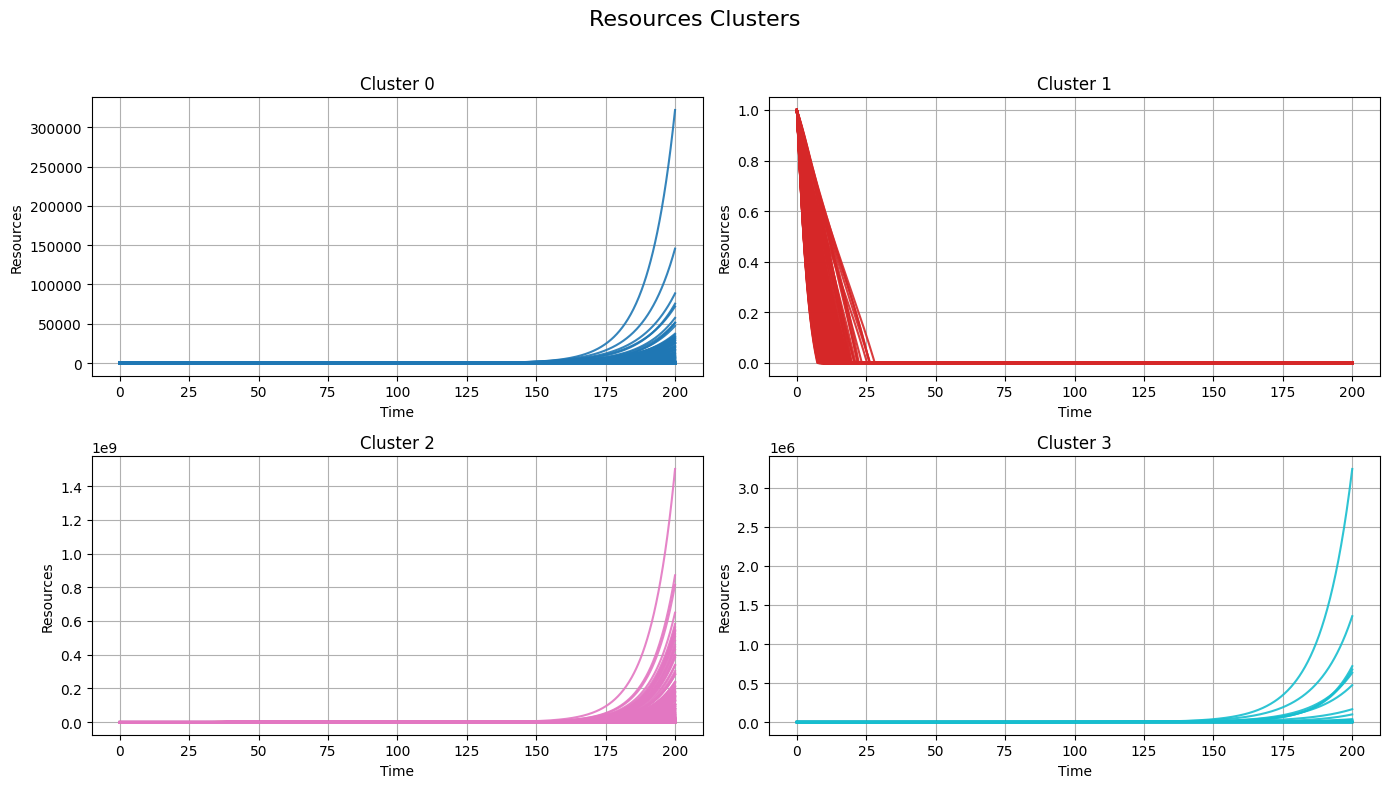

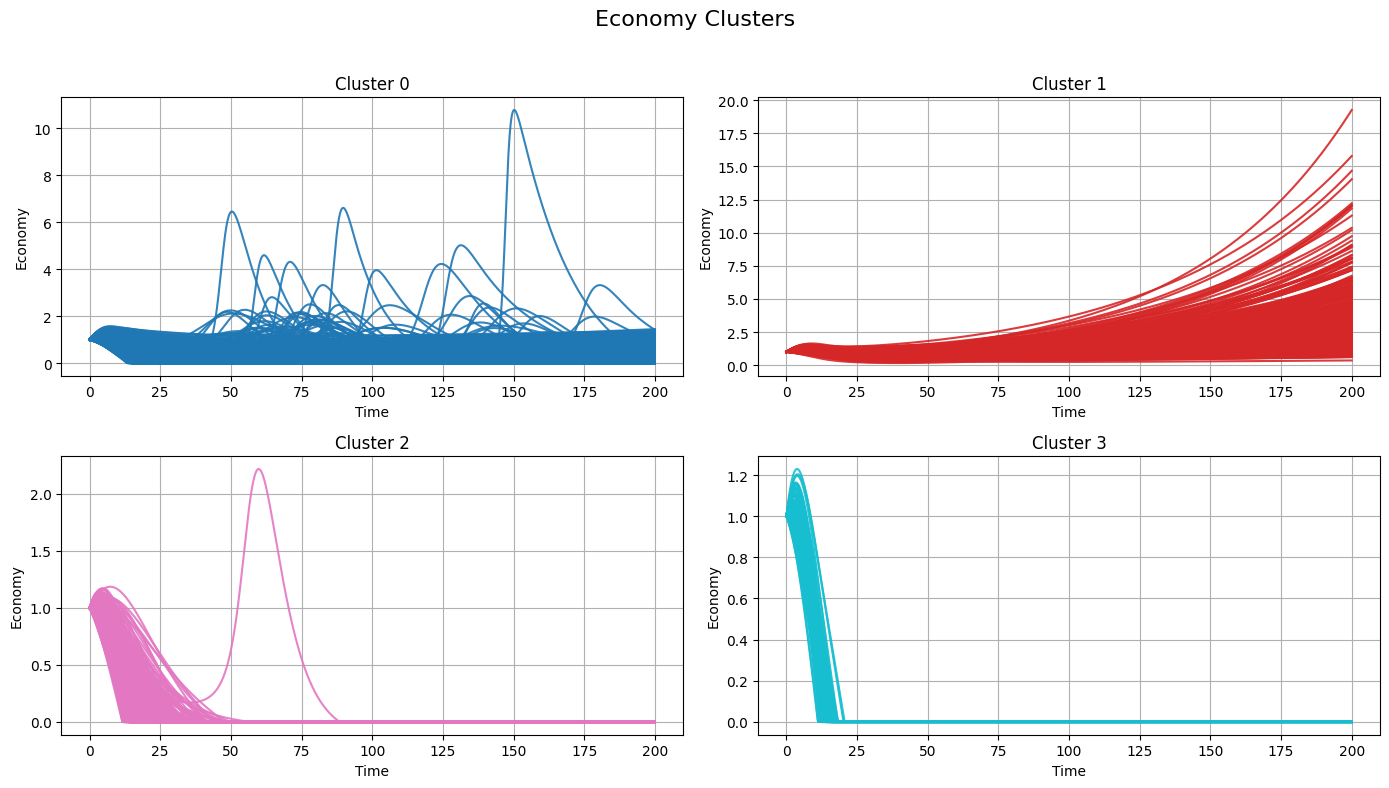

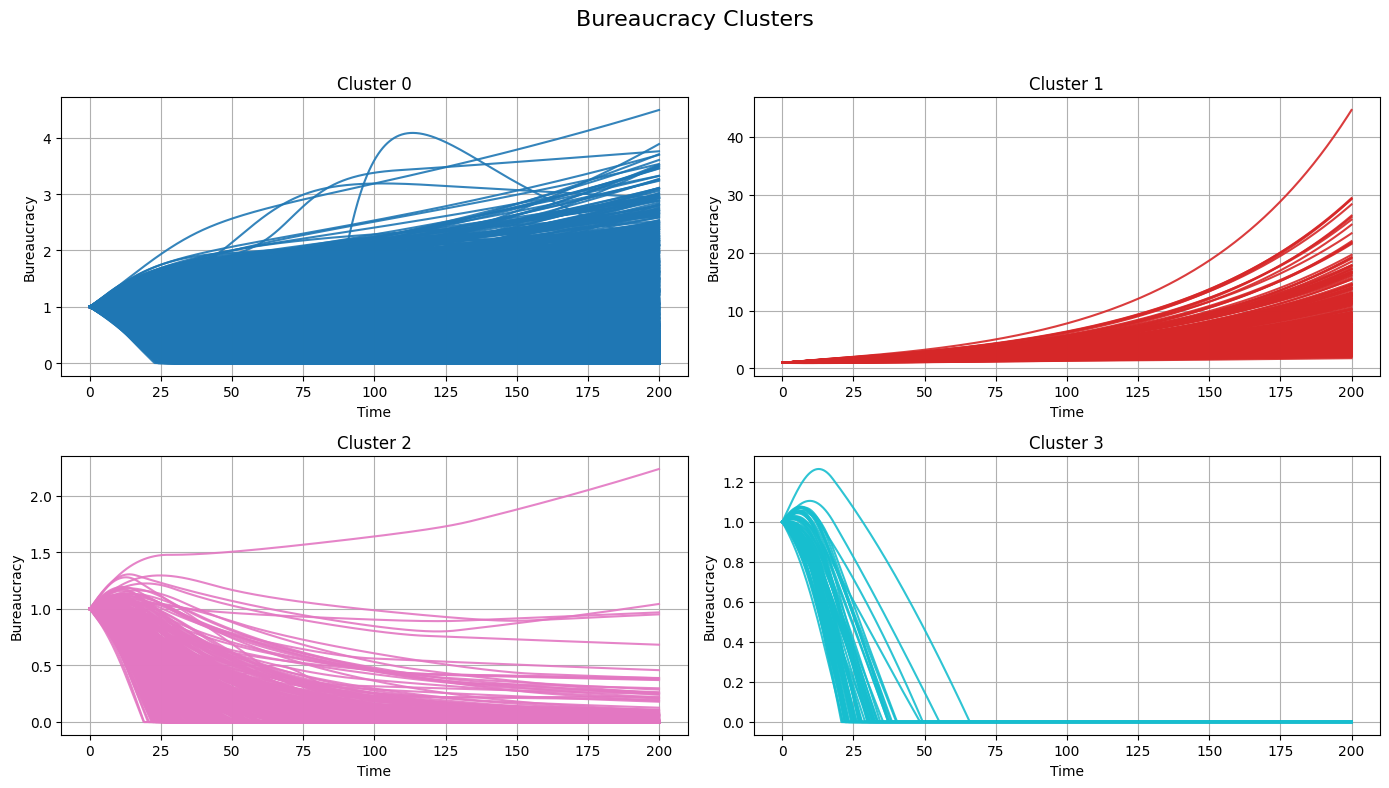

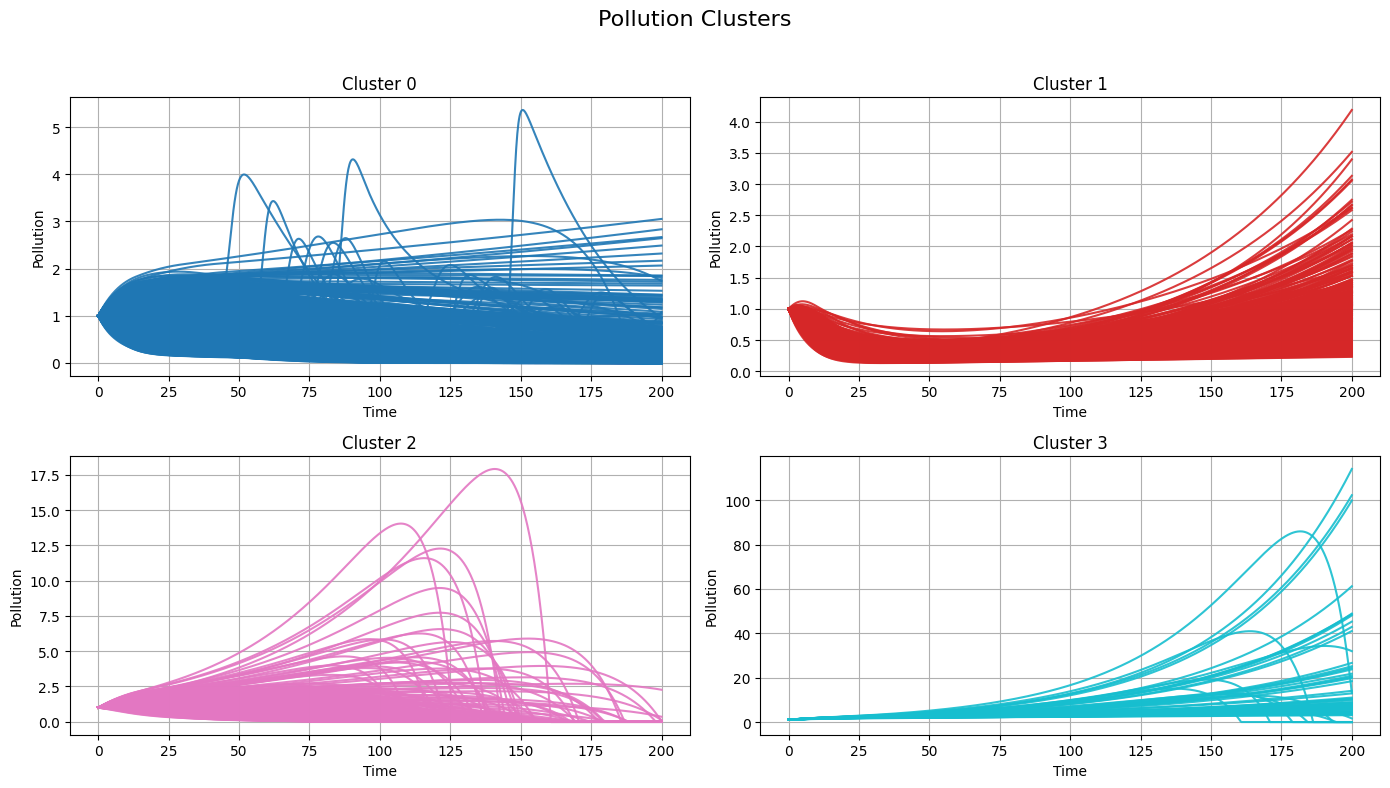

In [33]:
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Resources')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Economy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Bureaucracy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Pollution')

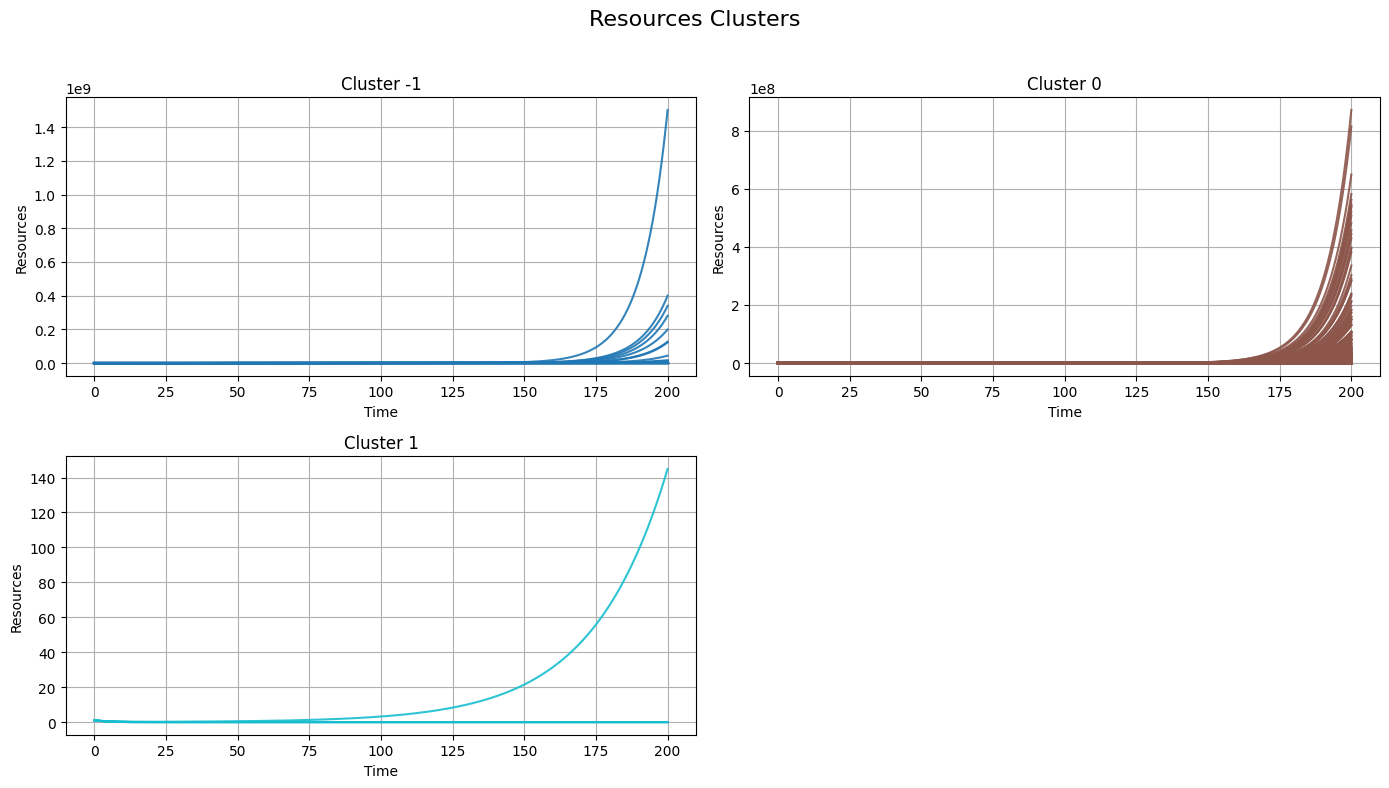

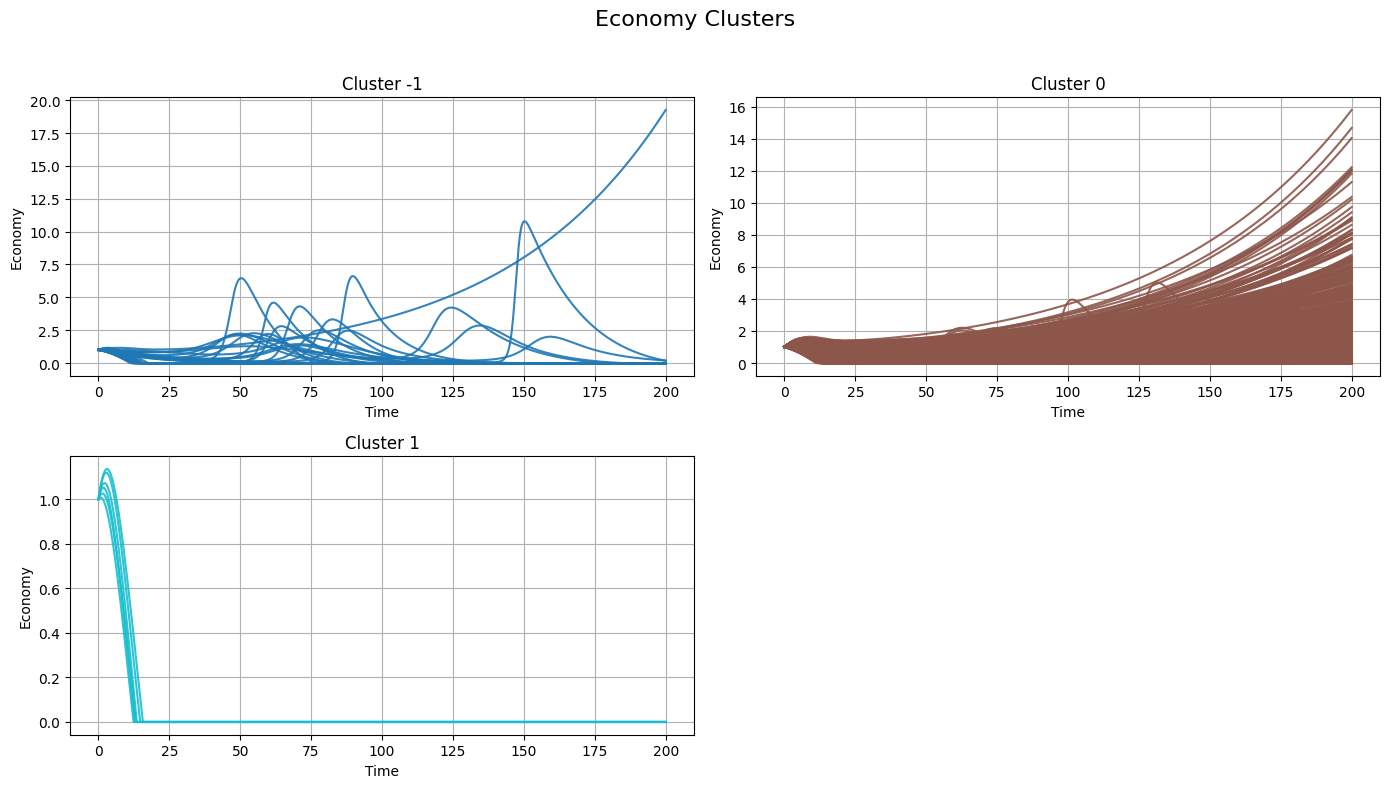

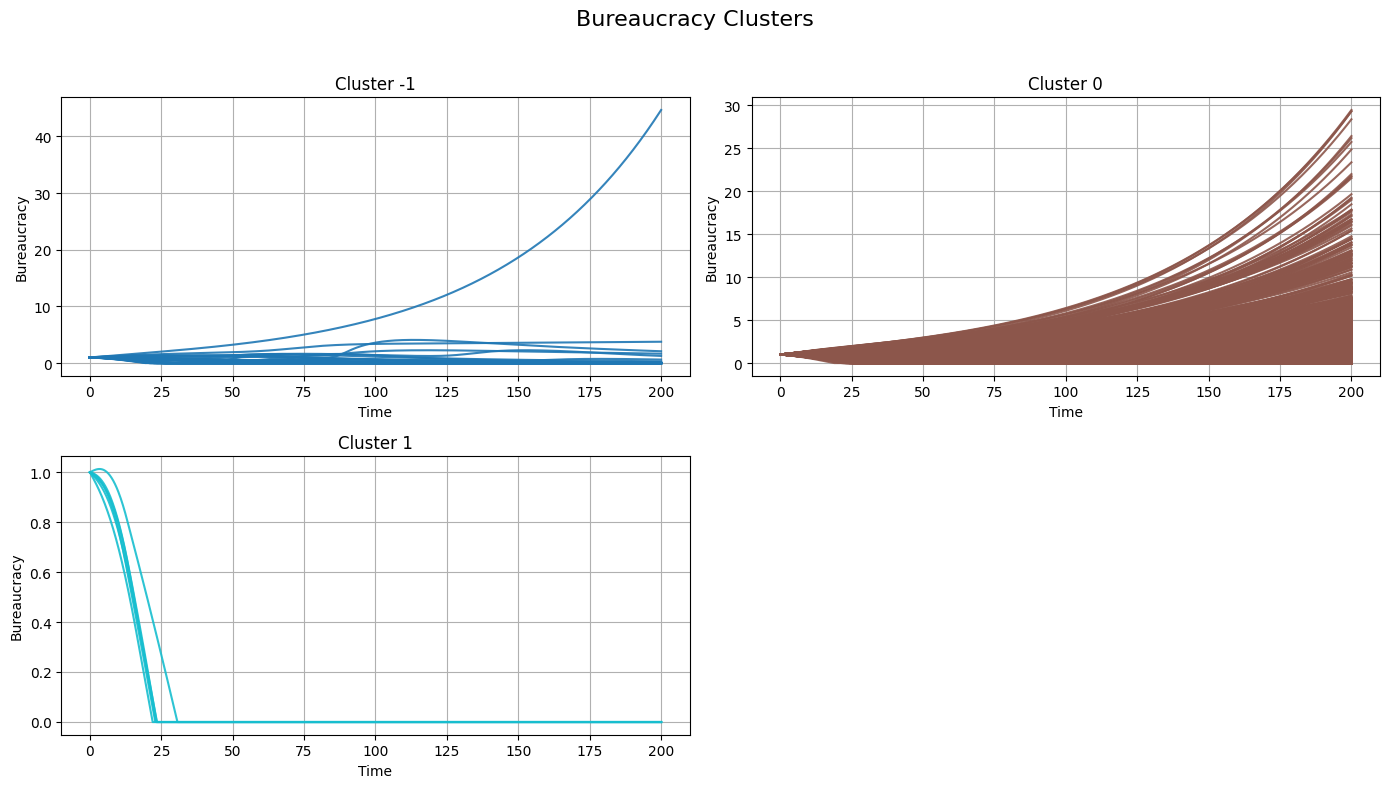

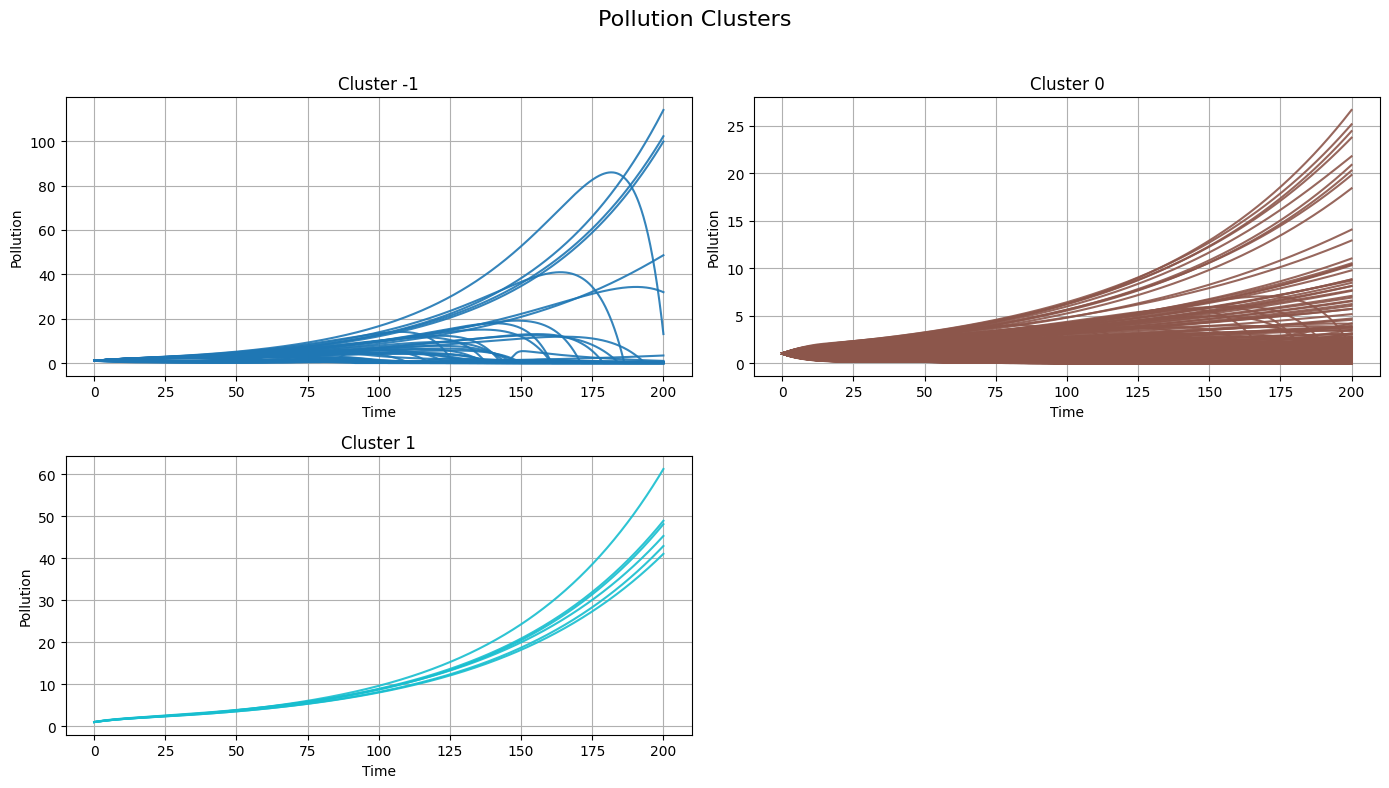

In [ ]:
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Resources')
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Economy')
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Bureaucracy')
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Pollution')

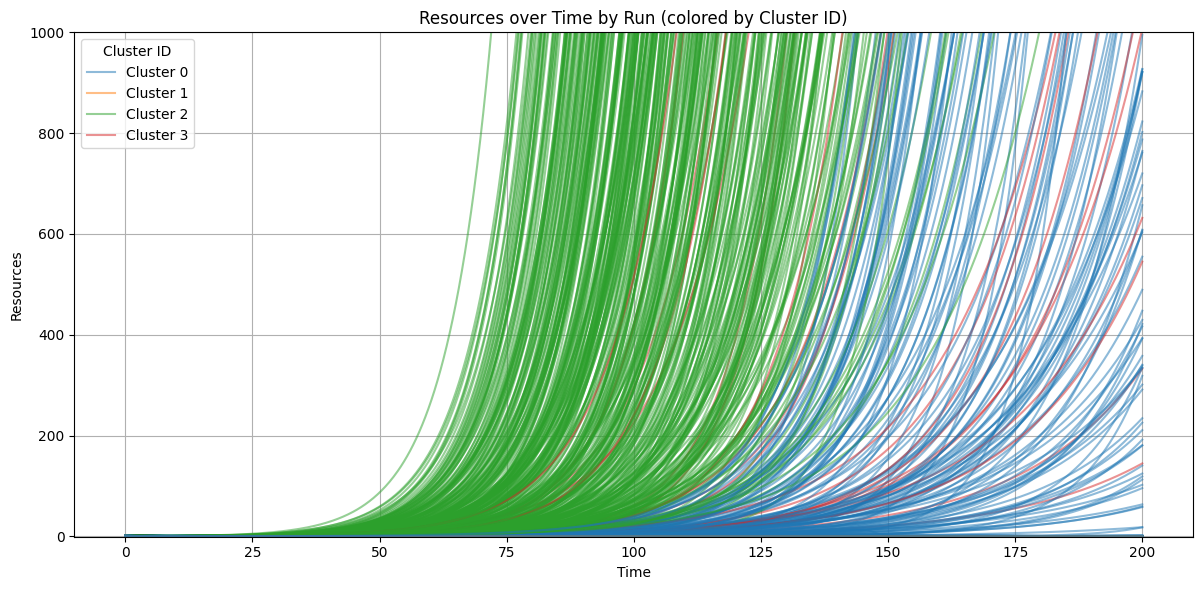

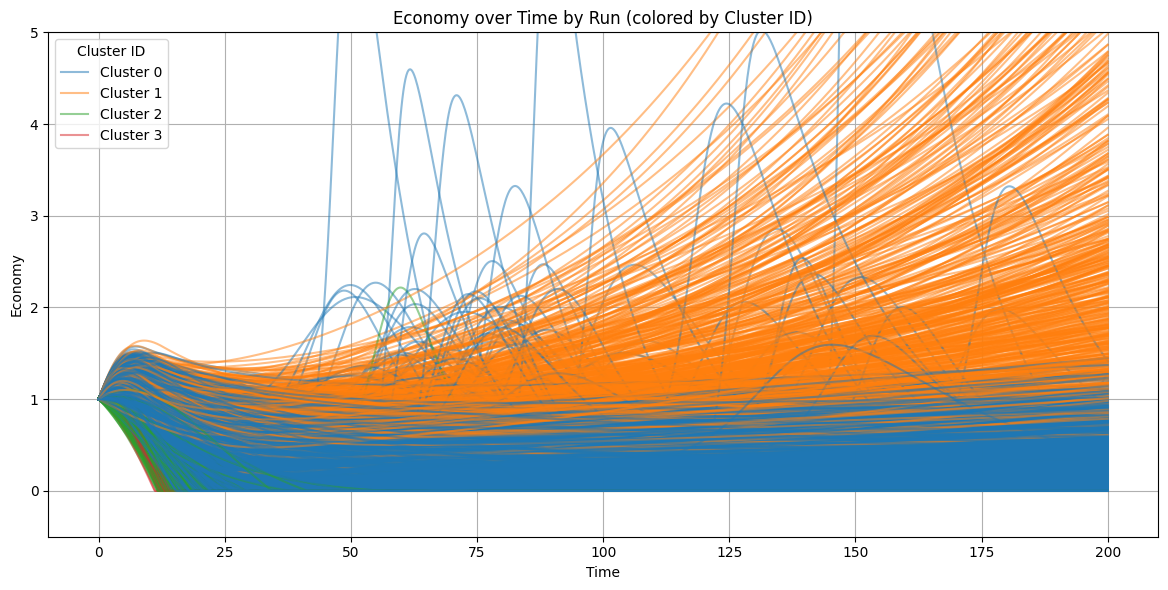

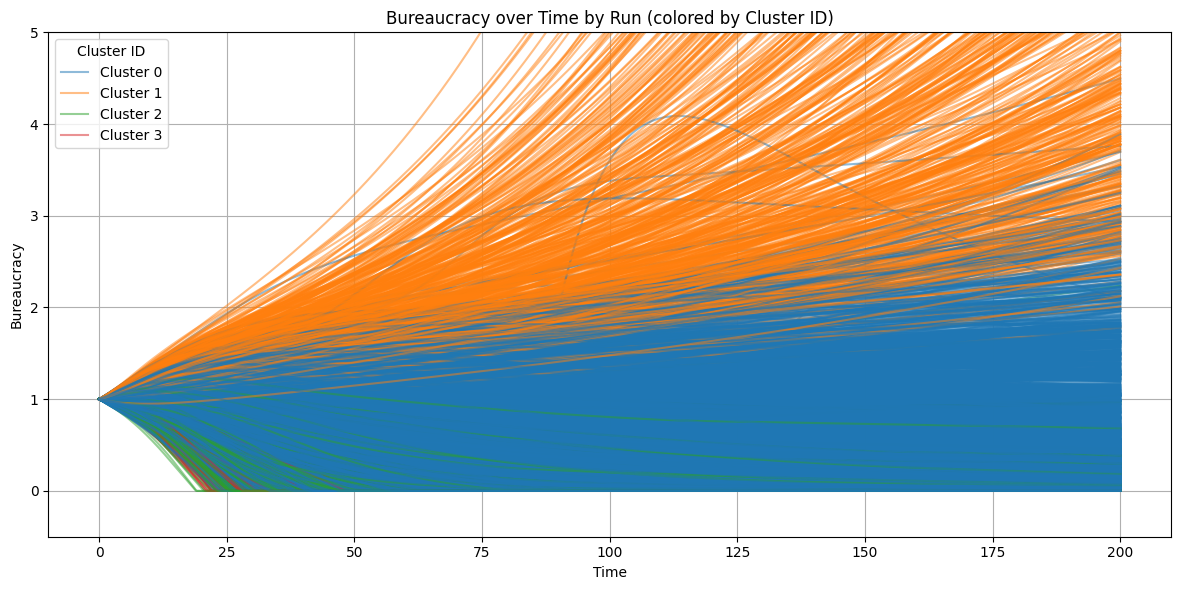

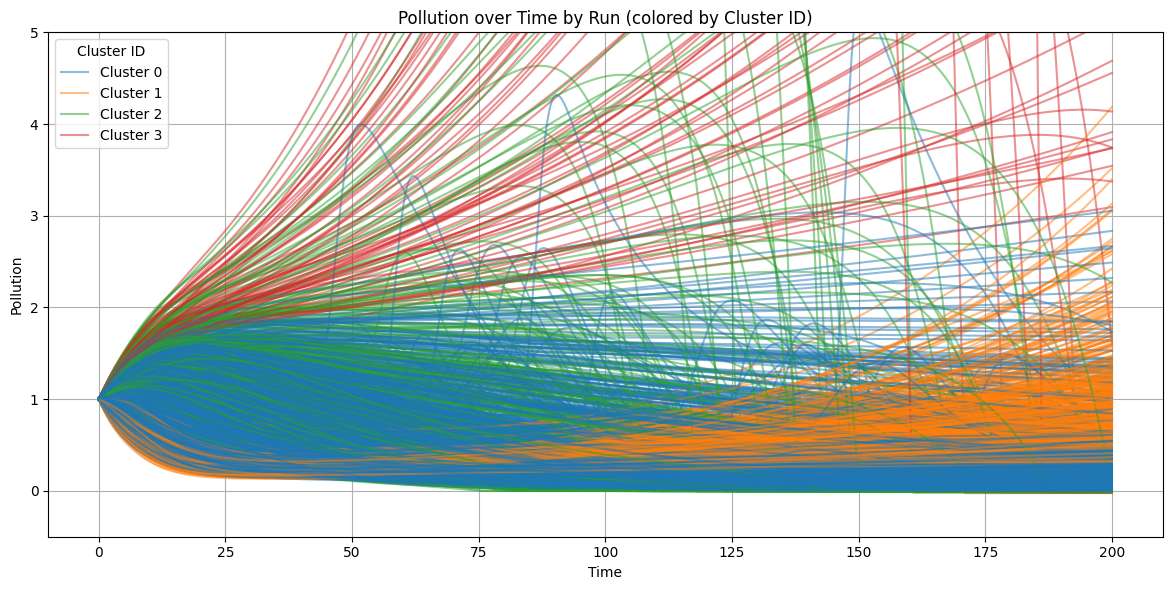

In [ ]:
plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Resources', ylim=(-0.5, 1000))
plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Economy', ylim=(-0.5, 5))
plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Bureaucracy', ylim=(-0.5, 5))
plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Pollution', ylim=(-0.5, 5))